In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

# os
import os

# Path
from pathlib import Path

# random
import random

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")

/Users/vishnugupta2711/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGE_PATH = Path("/Users/vishnugupta2711/Downloads/Pharmaceutical and Biomedical Waste (PBW)")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*/*.jpg"))
print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 6156


In [3]:
CLASSES = os.listdir(IMAGE_PATH)
CLASSES = sorted(CLASSES)

print(f"Total Classes = {len(CLASSES)}:\n")
for label in CLASSES:
    total_images_class = list(Path(os.path.join(IMAGE_PATH,label)).glob("*/*.jpg"))
    print(f'* {label}: {len(total_images_class)} images')

Total Classes = 13:

* (BT) Body Tissue or Organ: 474 images
* (GE) Glass equipment-packaging 551: 551 images
* (ME) Metal equipment -packaging: 426 images
* (OW) Organic wastes: 583 images
* (PE) Plastic equipment-packaging: 558 images
* (PP) Paper equipment-packaging: 457 images
* (SN) Syringe needles: 513 images
* .DS_Store: 0 images
* Gauze: 510 images
* Gloves: 543 images
* Mask: 529 images
* Syringe: 473 images
* Tweezers: 539 images


In [1]:

NUM_IMAGES = 2

# Get only the classes that have at least NUM_IMAGES images
valid_classes = []
for label in CLASSES:
    total_images_class = list((IMAGE_PATH / label).glob("**/*.jpg"))
    if len(total_images_class) >= NUM_IMAGES:
        valid_classes.append(label)
    else:
        print(f"Skipping class '{label}' (Not enough images)")

# Create subplot grid dynamically based on valid classes
fig, ax = plt.subplots(nrows=len(valid_classes), ncols=NUM_IMAGES, figsize=(20, max(5, len(valid_classes) * 2)))

# If there is only one valid class, ax will not be a 2D array → Ensure it's always a list of lists
if len(valid_classes) == 1:
    ax = [ax]

# Display images
for p, label in enumerate(valid_classes):
    total_images_class = list((IMAGE_PATH / label).glob("**/*.jpg"))
    total_selected = random.choices(total_images_class, k=NUM_IMAGES)

    for i, img_path in enumerate(total_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p][i].imshow(img_rgb)
        ax[p][i].axis("off")
        ax[p][i].set_title(f"Class: {label}\nShape: {img_rgb.shape}")

fig.tight_layout()
plt.show()


NameError: name 'CLASSES' is not defined

In [5]:
images_path_train = []
labels_train = []

images_path_test = []
labels_test = []

for i in IMAGE_PATH_LIST:
    if i.parent.stem == 'Train images':  # Check if image is in "Train images" folder
        images_path_train.append(i)
        labels_train.append(i.parent.parent.stem)  # Parent folder of "Train images" is the class name
        
    elif i.parent.stem == 'Test images':  # Check if image is in "Test images" folder
        images_path_test.append(i)
        labels_test.append(i.parent.parent.stem)  # Parent folder of "Test images" is the class name


In [6]:
data_train = pd.DataFrame({'Image': [str(img) for img in images_path_train], 'Label': labels_train})
data_train.head()


,Image,Label
0,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes
1,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes
2,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes
3,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes
4,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes


In [7]:
data_testing = pd.DataFrame({'Image': [str(img) for img in images_path_test], 'Label': labels_test})
data_testing.head()


,Image,Label
0,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes
1,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes
2,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes
3,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes
4,/Users/vishnugupta2711/Downloads/Pharmaceutica...,(OW) Organic wastes


In [8]:
SEED = 42

data_training, data_validation = tts(data_train, test_size=0.3, random_state=SEED, shuffle=True)

print(data_training.shape)
print(data_validation.shape)


(3432, 2)
(1471, 2)


In [9]:
label2id = dict(zip(CLASSES, range(len(CLASSES))))
label2id


{'(BT) Body Tissue or Organ': 0,
 '(GE) Glass equipment-packaging 551': 1,
 '(ME) Metal equipment -packaging': 2,
 '(OW) Organic wastes': 3,
 '(PE) Plastic equipment-packaging': 4,
 '(PP) Paper equipment-packaging': 5,
 '(SN) Syringe needles': 6,
 '.DS_Store': 7,
 'Gauze': 8,
 'Gloves': 9,
 'Mask': 10,
 'Syringe': 11,
 'Tweezers': 12}

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, data: pd.DataFrame, label_map: dict, transforms):
        self.data = data.copy()  # Store a copy to avoid modifying the original dataframe
        self.data['Label'] = self.data['Label'].map(label_map)  # Map labels once
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]  # Get image path
        image = Image.open(image_path).convert("RGB")  # Open image
        image = self.transforms(image)  # Apply transformations

        label = self.data.iloc[idx, 1]  # Get mapped label
        
        return image, label


In [11]:
weights = ViT_B_16_Weights.DEFAULT
image_transforms = weights.transforms()
image_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
train_dataset = CustomImageDataset(data_training, label2id, image_transforms)

val_dataset = CustomImageDataset(data_validation, label2id, image_transforms)

In [13]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, 
                              shuffle=True, num_workers=NUM_WORKERS)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, 
                            shuffle=False, num_workers=NUM_WORKERS)  # Shuffle=False


In [14]:
from custom_dataset import CustomImageDataset


In [15]:
train_dataset = CustomImageDataset(data_training, label2id, image_transforms)
val_dataset = CustomImageDataset(data_validation, label2id, image_transforms)

BATCH_SIZE = 32
NUM_WORKERS = 0  # Set to 0 in Jupyter Notebook to avoid multiprocessing issues

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Check batch dimensions
batch_images, batch_labels = next(iter(train_dataloader))
batch_images.shape, batch_labels.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [16]:
batch_images, batch_labels = next(iter(train_dataloader))
batch_images.shape, batch_labels.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [17]:
# GPU

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [18]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load model with pre-trained weights
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)


In [19]:
# We visualize the architecture of our model.
summary(model = model, input_size = [32, 3, 224, 224], col_width = 15, 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000]      768             True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         True
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]  [3

In [20]:
for param in model.conv_proj.parameters():
    param.requires_grad = False
    
for param in model.encoder.parameters():
    param.requires_grad = False

In [21]:
# We see if the extractor layers freeze.
summary(model = model, input_size = [32, 3, 224, 224], col_width = 15, 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000]      768             Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         False
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 

In [22]:
# We modify the output layer.
output_shape = len(CLASSES)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, out_features = output_shape))]))

In [23]:
# We view one last time to check if they were modified correctly.
summary(model = model, input_size = [32, 3, 224, 224], col_width = 15, 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 13]        768             Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         False
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

In [25]:

class EarlyStopping:
    def __init__(self, patience: int = 10, delta: float = 0.0001, path: str = "best_model.pth"):
        """
        Early stopping to stop training when validation loss does not improve.

        Args:
        - patience (int): Number of epochs to wait for improvement before stopping.
        - delta (float): Minimum change in validation loss to qualify as an improvement.
        - path (str): File path to save the best model checkpoint.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss: float, model: torch.nn.Module):
        """
        Checks validation loss and determines whether to stop training early.

        Args:
        - val_loss (float): Current validation loss.
        - model (torch.nn.Module): Model being trained.
        """
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            print(f"🔹 Initial best validation loss: {val_loss:.6f}")

        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            print(f"⚠️ No improvement ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.early_stop = True
                print("⏹️ Early stopping triggered!")

        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            print(f"✅ Validation loss improved to {val_loss:.6f}. Model saved!")

    def save_checkpoint(self, model: torch.nn.Module):
        """Saves the best model checkpoint."""
        torch.save(model.cpu().state_dict(), self.path)  # Save on CPU for compatibility
        model.to(DEVICE)  # Move model back to GPU if necessary
        print(f"💾 Best model saved at: {self.path}")

    def load_best_model(self, model: torch.nn.Module):
        """Loads the best model from checkpoint."""
        model.load_state_dict(torch.load(self.path))
        print("✅ Loaded best model from checkpoint.")


In [26]:
early_stopping = EarlyStopping(patience=20, delta=0.0001)


In [27]:


def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    
    model.train()  # Set model to training mode
    
    train_loss = 0
    train_accuracy = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device=DEVICE, dtype=torch.float32)
        y = y.to(device=DEVICE, dtype=torch.long)
        
        optimizer.zero_grad()  # Reset gradients
        
        y_pred_logit = model(X)  # Forward pass
        loss = loss_fn(y_pred_logit, y)  # Compute loss
        train_loss += loss.item()  # Accumulate loss
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        # Convert logits to predicted class probabilities
        y_pred_prob = torch.softmax(y_pred_logit, dim=1)
        y_pred_class = y_pred_prob.argmax(dim=1)

        # Compute accuracy using balanced_accuracy_score
        batch_accuracy = balanced_accuracy_score(y.cpu().numpy(), y_pred_class.cpu().numpy())
        train_accuracy += batch_accuracy

    # Average loss and accuracy over all batches
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)
    
    return train_loss, train_accuracy


In [28]:
def val_step(model: torch.nn.Module, 
             dataloader: torch.utils.data.DataLoader, 
             loss_fn: torch.nn.Module):
    
    model.eval()  # Set model to evaluation mode
    
    val_loss = 0
    val_accuracy = 0
    
    with torch.no_grad():  # Disable gradient computation
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device=DEVICE, dtype=torch.float32)
            y = y.to(device=DEVICE, dtype=torch.long)
            
            y_pred_logit = model(X)  # Forward pass
            loss = loss_fn(y_pred_logit, y)  # Compute loss
            val_loss += loss.item()  # Accumulate loss
            
            # Convert logits to predicted class
            y_pred_prob = torch.softmax(y_pred_logit, dim=1)
            y_pred_class = y_pred_prob.argmax(dim=1)

            # Compute accuracy using balanced_accuracy_score
            batch_accuracy = balanced_accuracy_score(y.cpu().numpy(), 
                                                     y_pred_class.cpu().numpy())
            val_accuracy += batch_accuracy

    # Compute mean loss and accuracy
    val_loss /= len(dataloader)
    val_accuracy /= len(dataloader)
    
    return val_loss, val_accuracy

In [29]:
def val_step(model: torch.nn.Module, 
             dataloader: torch.utils.data.DataLoader, 
             loss_fn: torch.nn.Module):
    
    model.eval()  # Set model to evaluation mode
    
    val_loss = 0
    val_accuracy = 0
    
    with torch.no_grad():  # Disable gradient computation
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device=DEVICE, dtype=torch.float32)
            y = y.to(device=DEVICE, dtype=torch.long)
            
            y_pred_logit = model(X)  # Forward pass
            loss = loss_fn(y_pred_logit, y)  # Compute loss
            val_loss += loss.item()  # Accumulate loss
            
            # Convert logits to predicted class
            y_pred_prob = torch.softmax(y_pred_logit, dim=1)
            y_pred_class = y_pred_prob.argmax(dim=1)

            # Compute accuracy using balanced_accuracy_score
            batch_accuracy = balanced_accuracy_score(y.cpu().numpy(), 
                                                     y_pred_class.cpu().numpy())
            val_accuracy += batch_accuracy

    # Compute mean loss and accuracy
    val_loss /= len(dataloader)
    val_accuracy /= len(dataloader)
    
    return val_loss, val_accuracy

In [30]:


def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer, early_stopping, epochs: int = 10):
    
    results = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in tqdm(range(epochs)):  # Show progress bar
        
        train_loss, train_accuracy = train_step(model=model, dataloader=train_dataloader, 
                                                loss_fn=loss_fn, optimizer=optimizer)
        
        val_loss, val_accuracy = val_step(model=model, dataloader=val_dataloader, 
                                          loss_fn=loss_fn)
        
        print(f'Epoch: {epoch + 1} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Train Accuracy: {train_accuracy:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'Val Accuracy: {val_accuracy:.4f}')
        
        # Apply early stopping
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("\nEarly Stopping!! Training stopped.")
            break
            
        # Store results
        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['val_loss'].append(val_loss)
        results['val_accuracy'].append(val_accuracy)
        
    return results


In [31]:
# Training !!!

EPOCHS = 50

torch.cuda.manual_seed(SEED) 
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), train_dataloader, val_dataloader, loss_fn, optimizer, early_stopping, EPOCHS)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.1441 | Train Accuracy: 0.9591 | Val Loss: 0.0280 | Val Accuracy: 0.9924


  2%|▊                                        | 1/50 [08:45<7:09:20, 525.73s/it]

💾 Best model saved at: best_model.pth
🔹 Initial best validation loss: 0.028048


  4%|█▋                                       | 2/50 [18:44<7:34:45, 568.45s/it]

Epoch: 2 | Train Loss: 0.0253 | Train Accuracy: 0.9931 | Val Loss: 0.0458 | Val Accuracy: 0.9896
⚠️ No improvement (1/20)
Epoch: 3 | Train Loss: 0.0222 | Train Accuracy: 0.9957 | Val Loss: 0.0201 | Val Accuracy: 0.9953


  6%|██▍                                      | 3/50 [28:32<7:32:35, 577.77s/it]

💾 Best model saved at: best_model.pth
✅ Validation loss improved to 0.020127. Model saved!


  8%|███▎                                     | 4/50 [38:30<7:29:02, 585.71s/it]

Epoch: 4 | Train Loss: 0.0205 | Train Accuracy: 0.9966 | Val Loss: 0.0221 | Val Accuracy: 0.9948
⚠️ No improvement (1/20)
Epoch: 5 | Train Loss: 0.0312 | Train Accuracy: 0.9979 | Val Loss: 0.0161 | Val Accuracy: 0.9949


 10%|████                                     | 5/50 [53:40<8:46:54, 702.54s/it]

💾 Best model saved at: best_model.pth
✅ Validation loss improved to 0.016142. Model saved!


 12%|████▋                                  | 6/50 [1:06:44<8:55:31, 730.26s/it]

Epoch: 6 | Train Loss: 0.0154 | Train Accuracy: 0.9973 | Val Loss: 0.0396 | Val Accuracy: 0.9957
⚠️ No improvement (1/20)


 14%|█████▍                                 | 7/50 [1:17:02<8:17:04, 693.60s/it]

Epoch: 7 | Train Loss: 0.0278 | Train Accuracy: 0.9982 | Val Loss: 0.0251 | Val Accuracy: 0.9942
⚠️ No improvement (2/20)
Epoch: 8 | Train Loss: 0.0149 | Train Accuracy: 0.9967 | Val Loss: 0.0130 | Val Accuracy: 0.9967


 16%|██████▏                                | 8/50 [1:27:16<7:47:42, 668.16s/it]

💾 Best model saved at: best_model.pth
✅ Validation loss improved to 0.012961. Model saved!


 18%|███████                                | 9/50 [1:41:17<8:13:33, 722.28s/it]

Epoch: 9 | Train Loss: 0.0032 | Train Accuracy: 0.9990 | Val Loss: 0.0536 | Val Accuracy: 0.9926
⚠️ No improvement (1/20)


 20%|███████▌                              | 10/50 [1:50:47<7:30:09, 675.25s/it]

Epoch: 10 | Train Loss: 0.0148 | Train Accuracy: 0.9986 | Val Loss: 0.0155 | Val Accuracy: 0.9969
⚠️ No improvement (2/20)


 22%|████████▎                             | 11/50 [2:00:21<6:58:48, 644.32s/it]

Epoch: 11 | Train Loss: 0.0231 | Train Accuracy: 0.9979 | Val Loss: 0.0420 | Val Accuracy: 0.9872
⚠️ No improvement (3/20)


 24%|█████████                             | 12/50 [2:10:31<6:41:28, 633.90s/it]

Epoch: 12 | Train Loss: 0.0279 | Train Accuracy: 0.9960 | Val Loss: 0.0187 | Val Accuracy: 0.9923
⚠️ No improvement (4/20)


 26%|█████████▉                            | 13/50 [2:19:43<6:15:29, 608.91s/it]

Epoch: 13 | Train Loss: 0.0358 | Train Accuracy: 0.9920 | Val Loss: 0.0262 | Val Accuracy: 0.9909
⚠️ No improvement (5/20)


 28%|██████████▋                           | 14/50 [2:36:58<7:22:33, 737.60s/it]

Epoch: 14 | Train Loss: 0.0462 | Train Accuracy: 0.9891 | Val Loss: 0.0557 | Val Accuracy: 0.9863
⚠️ No improvement (6/20)


 30%|███████████▍                          | 15/50 [2:57:50<8:40:42, 892.65s/it]

Epoch: 15 | Train Loss: 0.0427 | Train Accuracy: 0.9914 | Val Loss: 0.0547 | Val Accuracy: 0.9899
⚠️ No improvement (7/20)


 32%|███████████▌                        | 16/50 [3:31:27<11:37:35, 1231.04s/it]

Epoch: 16 | Train Loss: 0.0273 | Train Accuracy: 0.9932 | Val Loss: 0.0349 | Val Accuracy: 0.9939
⚠️ No improvement (8/20)


 34%|████████████▏                       | 17/50 [5:29:26<27:24:15, 2989.56s/it]

Epoch: 17 | Train Loss: 0.0038 | Train Accuracy: 0.9984 | Val Loss: 0.0287 | Val Accuracy: 0.9940
⚠️ No improvement (9/20)


 36%|████████████▉                       | 18/50 [7:51:25<41:20:40, 4651.25s/it]

Epoch: 18 | Train Loss: 0.0104 | Train Accuracy: 0.9987 | Val Loss: 0.0198 | Val Accuracy: 0.9969
⚠️ No improvement (10/20)


 38%|█████████████▋                      | 19/50 [9:09:16<40:06:06, 4656.98s/it]

Epoch: 19 | Train Loss: 0.0133 | Train Accuracy: 0.9979 | Val Loss: 0.0162 | Val Accuracy: 0.9968
⚠️ No improvement (11/20)


 40%|██████████████▍                     | 20/50 [9:41:50<32:02:46, 3845.55s/it]

Epoch: 20 | Train Loss: 0.0130 | Train Accuracy: 0.9986 | Val Loss: 0.0203 | Val Accuracy: 0.9937
⚠️ No improvement (12/20)


 42%|██████████████▋                    | 21/50 [10:05:38<25:07:53, 3119.79s/it]

Epoch: 21 | Train Loss: 0.0077 | Train Accuracy: 0.9988 | Val Loss: 0.0168 | Val Accuracy: 0.9972
⚠️ No improvement (13/20)


 44%|███████████████▍                   | 22/50 [10:55:27<23:57:40, 3080.75s/it]

Epoch: 22 | Train Loss: 0.0085 | Train Accuracy: 0.9990 | Val Loss: 0.0169 | Val Accuracy: 0.9944
⚠️ No improvement (14/20)


 46%|████████████████                   | 23/50 [11:39:26<22:06:35, 2947.96s/it]

Epoch: 23 | Train Loss: 0.0003 | Train Accuracy: 0.9996 | Val Loss: 0.0189 | Val Accuracy: 0.9976
⚠️ No improvement (15/20)


 48%|████████████████▊                  | 24/50 [12:01:18<17:44:48, 2457.27s/it]

Epoch: 24 | Train Loss: 0.0003 | Train Accuracy: 1.0000 | Val Loss: 0.0258 | Val Accuracy: 0.9950
⚠️ No improvement (16/20)


 50%|█████████████████▌                 | 25/50 [12:45:06<17:25:09, 2508.38s/it]

Epoch: 25 | Train Loss: 0.0054 | Train Accuracy: 0.9988 | Val Loss: 0.0133 | Val Accuracy: 0.9978
⚠️ No improvement (17/20)


 52%|██████████████████▏                | 26/50 [12:58:24<13:18:04, 1995.17s/it]

Epoch: 26 | Train Loss: 0.0074 | Train Accuracy: 0.9994 | Val Loss: 0.0507 | Val Accuracy: 0.9928
⚠️ No improvement (18/20)


 54%|██████████████████▉                | 27/50 [13:15:40<10:54:34, 1707.57s/it]

Epoch: 27 | Train Loss: 0.0210 | Train Accuracy: 0.9981 | Val Loss: 0.0259 | Val Accuracy: 0.9958
⚠️ No improvement (19/20)


 54%|██████████████████▉                | 27/50 [13:29:58<11:29:58, 1799.93s/it]

Epoch: 28 | Train Loss: 0.0091 | Train Accuracy: 0.9981 | Val Loss: 0.0260 | Val Accuracy: 0.9953
⚠️ No improvement (20/20)
⏹️ Early stopping triggered!

Early Stopping!! Training stopped.


In [32]:
import matplotlib.pyplot as plt

# Function to plot training and validation loss/metric
def metric_and_loss_plot(results: dict):
    training_loss = results['train_loss']
    training_accuracy = results['train_accuracy']
    
    valid_loss = results['val_loss']
    valid_accuracy = results['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ax = ax.flat  # Flatten in case we change the grid in the future
    
    # Plot Loss
    ax[0].plot(training_loss, color="red", label="Train Loss")
    ax[0].plot(valid_loss, color="blue", label="Val Loss")
    ax[0].set_title("CrossEntropyLoss", fontsize=12, fontweight="bold", color="black")
    ax[0].set_xlabel("Epoch", fontsize=10, fontweight="bold", color="black")
    ax[0].set_ylabel("Loss", fontsize=10, fontweight="bold", color="black")
    ax[0].legend()
    
    # Plot Accuracy
    ax[1].plot(training_accuracy, color="red", label="Train Accuracy")
    ax[1].plot(valid_accuracy, color="blue", label="Val Accuracy")
    ax[1].set_title("Balanced Accuracy", fontsize=12, fontweight="bold", color="black")
    ax[1].set_xlabel("Epoch", fontsize=10, fontweight="bold", color="black")
    ax[1].set_ylabel("Score", fontsize=10, fontweight="bold", color="black")
    ax[1].legend()
    
    fig.tight_layout()
    plt.show()  # Correct way to display the plot


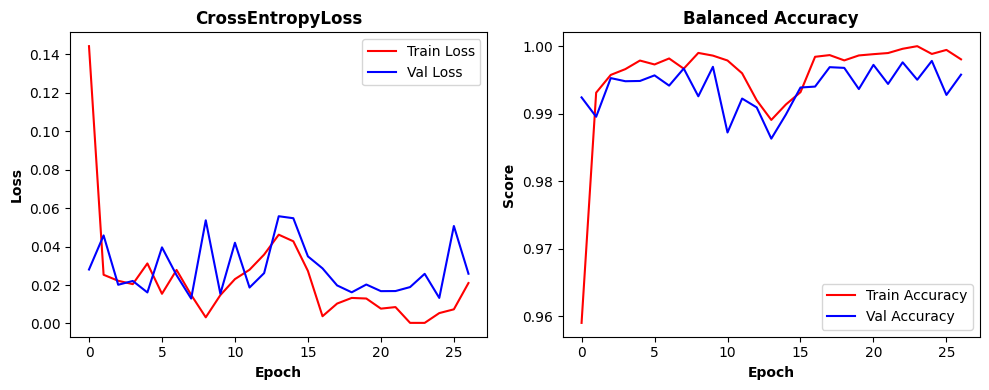

In [33]:
metric_and_loss_plot(RESULTS)

In [34]:

import torch
from collections import OrderedDict
from torchvision.models import vit_b_16
from torch import nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predictions(test_dataloader: torch.utils.data.DataLoader):
    # Load checkpoint
    checkpoint = torch.load("best_model.pth", map_location=DEVICE)

    # Load ViT model
    loaded_model = vit_b_16()

    # Set output shape correctly (use 13 if trained with 13 classes)
    output_shape = 13  # Ensure it matches the trained model
    
    # Modify classification head
    loaded_model.heads.head = nn.Linear(in_features=768, out_features=output_shape)

    # Load state_dict with strict=False to avoid mismatches
    missing_keys, unexpected_keys = loaded_model.load_state_dict(checkpoint, strict=False)

    print("Missing keys:", missing_keys)   # Should show mismatched classification head
    print("Unexpected keys:", unexpected_keys)

    # Move to GPU/CPU
    loaded_model.to(DEVICE)
    loaded_model.eval()

    y_pred_test = []

    with torch.inference_mode():
        for X, _ in tqdm(test_dataloader):
            X = X.to(DEVICE, dtype=torch.float32)
            y_pred_logit = loaded_model(X)
            y_pred_prob = y_pred_logit.softmax(dim=1)
            y_pred_class = y_pred_prob.argmax(dim=1)
            y_pred_test.append(y_pred_class.cpu())

    y_pred_test = torch.cat(y_pred_test)

    return y_pred_test.cpu().numpy()  # Convert to NumPy if needed



In [35]:
# Ensure the dataset class is correctly defined
test_dataset = CustomImageDataset(data_testing, label2id, image_transforms)

# Ensure batch size and number of workers are defined
BATCH_SIZE = 32
NUM_WORKERS = 2  # Set to 0 if using Windows

# Create DataLoader
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, 
                             shuffle=False, num_workers=NUM_WORKERS)


In [36]:
# We make the predictions.
y_pred_test = predictions(test_dataloader)

Missing keys: []
Unexpected keys: []


100%|███████████████████████████████████████████| 40/40 [01:41<00:00,  2.53s/it]


In [37]:
from sklearn.metrics import balanced_accuracy_score

# Ensure y_pred_test is a NumPy array
if isinstance(y_pred_test, torch.Tensor):
    y_pred_test = y_pred_test.cpu().numpy()  # Convert only if necessary

# Compute balanced accuracy
test_accuracy = balanced_accuracy_score(
    data_testing['Label'].map(label2id), 
    y_pred_test
)

print(f"Balanced Accuracy Test = {test_accuracy:.4f}")


Balanced Accuracy Test = 0.9840


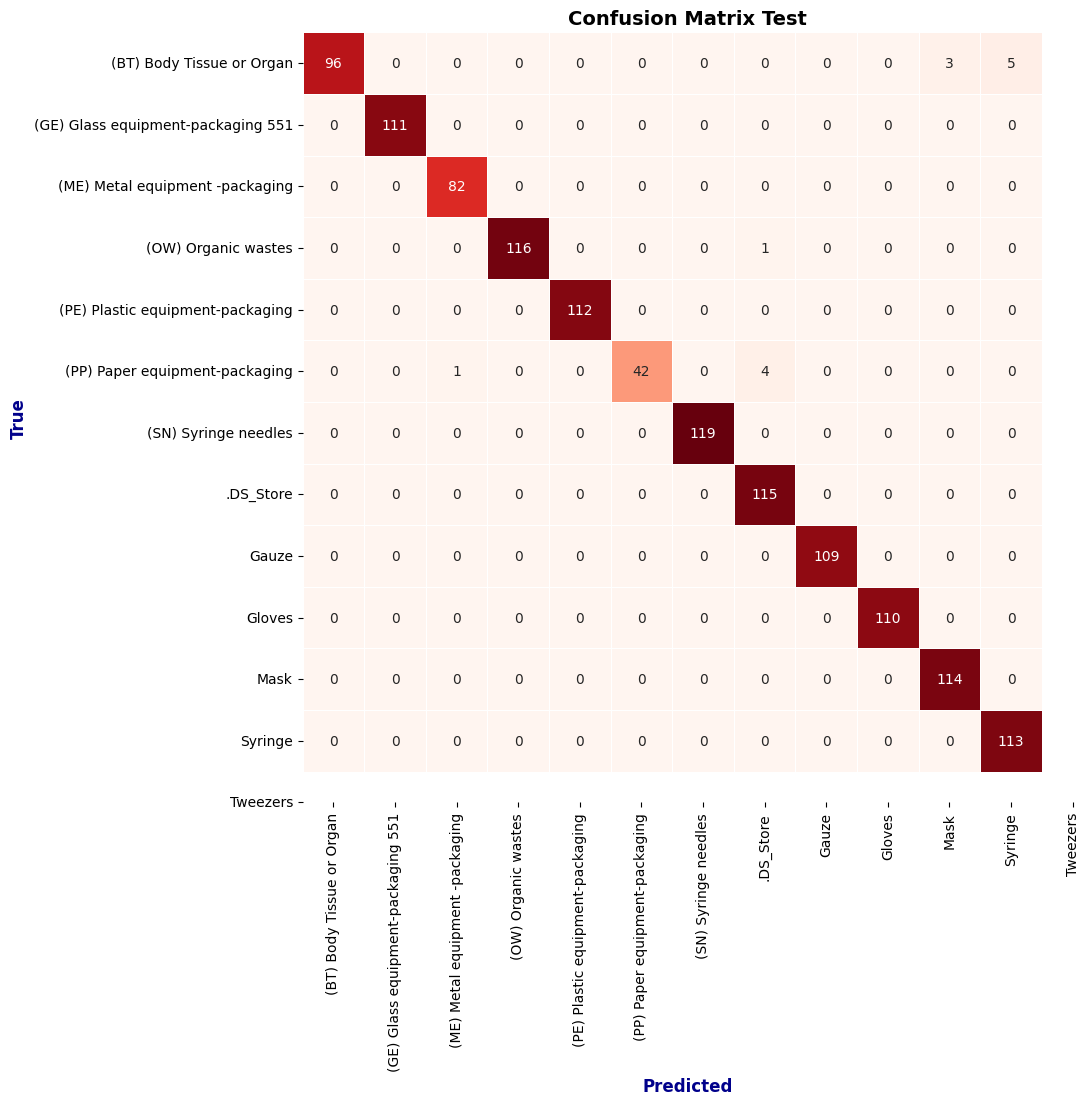

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert predictions to NumPy if they are still a tensor
if isinstance(y_pred_test, torch.Tensor):
    y_pred_test = y_pred_test.cpu().numpy()

# Compute the confusion matrix
cf_mx_test = confusion_matrix(data_testing['Label'].map(label2id), y_pred_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_mx_test, cmap='Reds', fmt='d', annot=True, cbar=False, square=True, linewidths=0.4, 
            xticklabels=CLASSES, yticklabels=CLASSES, ax=ax)

# Axis labels and title
ax.set_ylabel("True", color="darkblue", fontsize=12, fontweight="bold")
ax.set_xlabel("Predicted", color="darkblue", fontsize=12, fontweight="bold")
ax.set_title("Confusion Matrix Test", fontsize=14, fontweight="bold", color="black")

plt.show()  # Use plt.show() instead of fig.show() for proper display in Jupyter notebooks


In [39]:
!pip install opencv-python


In [42]:
import torch

# 🔹 Assuming 'model' is your trained model
torch.save(model.state_dict(), "best_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [43]:
import os
print("File exists:", os.path.exists("best_model.pth"))


File exists: True


In [44]:
import pickle

# Save training results (loss, accuracy, etc.)
with open("training_results.pkl", "wb") as f:
    pickle.dump(RESULTS, f)


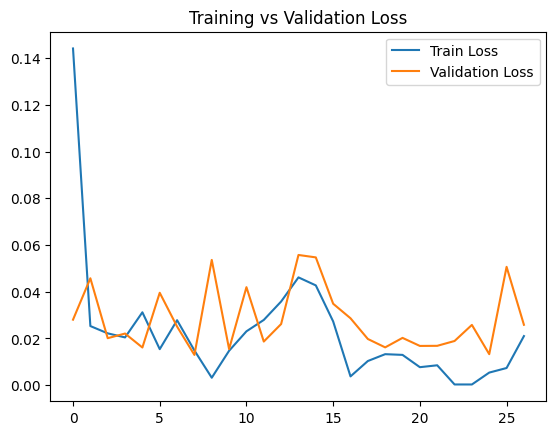

In [45]:
import matplotlib.pyplot as plt

# Example: Save Loss Plot
plt.plot(RESULTS["train_loss"], label="Train Loss")
plt.plot(RESULTS["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("loss_plot.png")  # Save the figure
plt.show()



🔹 Predictions for sample.webp:
Syringe: 99.93%
(OW) Organic wastes: 0.04%
(SN) Syringe needles: 0.01%


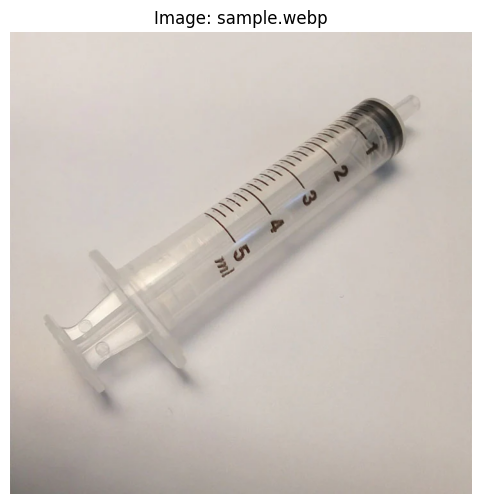

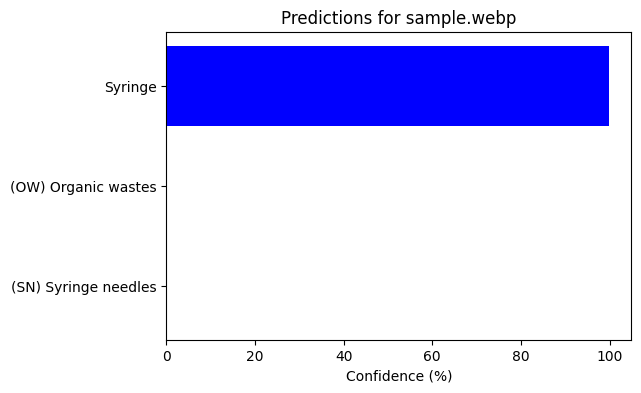


🔹 Predictions for ThreeTypesOfGauze.jpeg:
(PP) Paper equipment-packaging: 65.05%
Gauze: 12.34%
(SN) Syringe needles: 11.29%


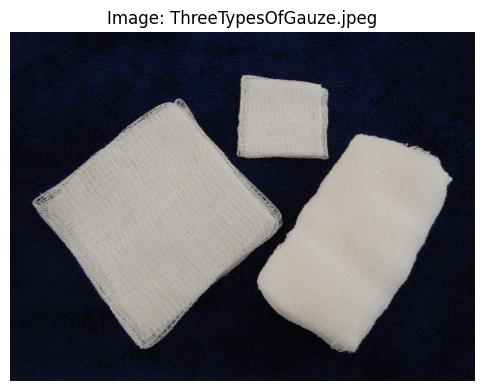

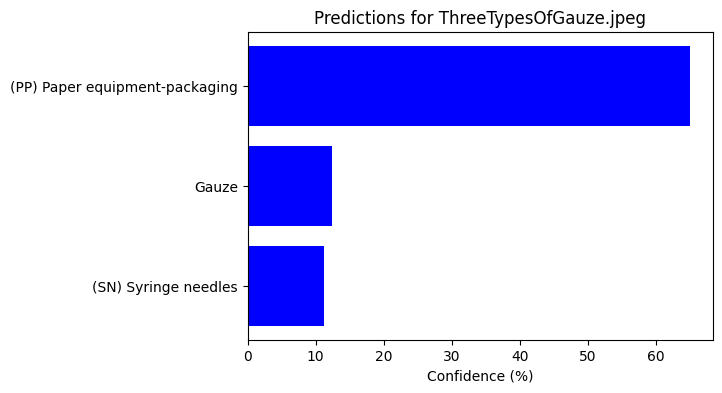


🔹 Predictions for glove.jpg:
Gloves: 100.00%
Tweezers: 0.00%
(PE) Plastic equipment-packaging: 0.00%


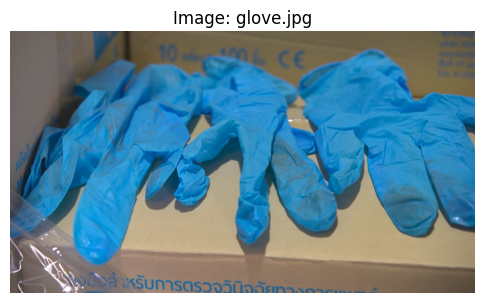

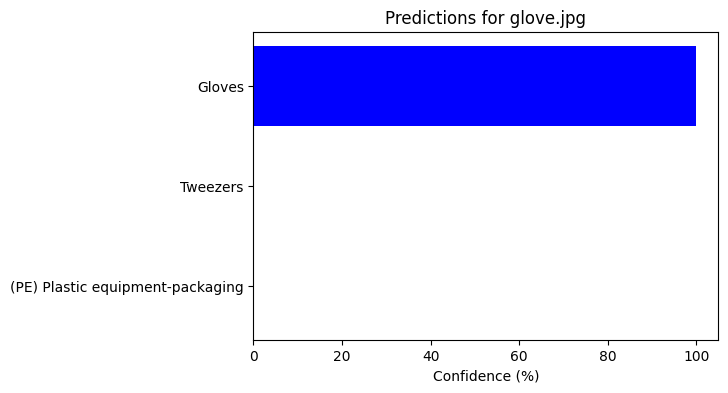


🔹 Predictions for lem.webp:
(OW) Organic wastes: 81.69%
(ME) Metal equipment -packaging: 6.79%
Tweezers: 5.49%


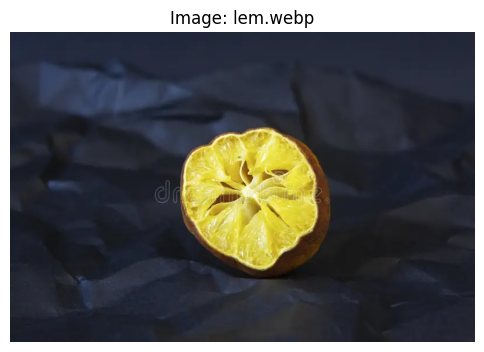

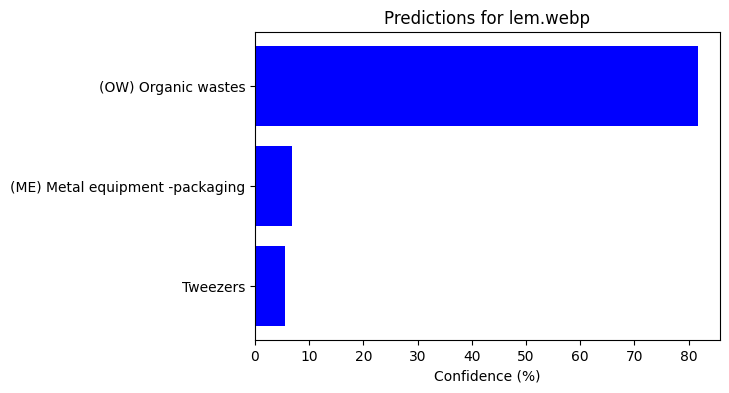


🔹 Predictions for con.webp:
(SN) Syringe needles: 58.90%
Syringe: 41.08%
(BT) Body Tissue or Organ: 0.01%


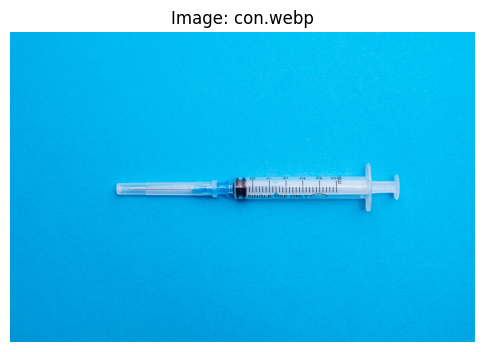

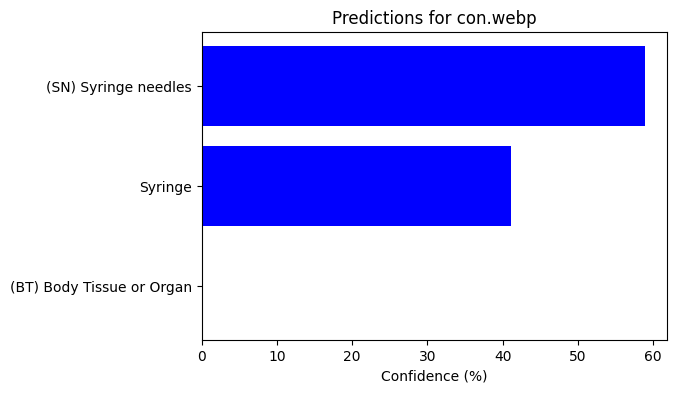


🔹 Predictions for tisu.jpg:
(BT) Body Tissue or Organ: 93.32%
Syringe: 2.65%
(SN) Syringe needles: 1.71%


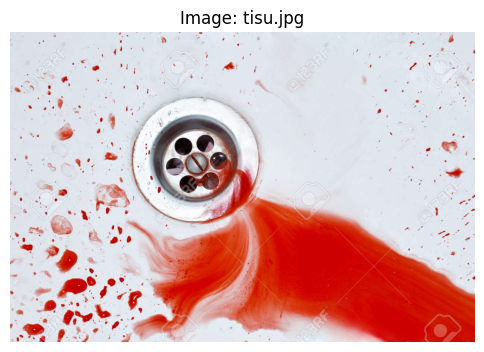

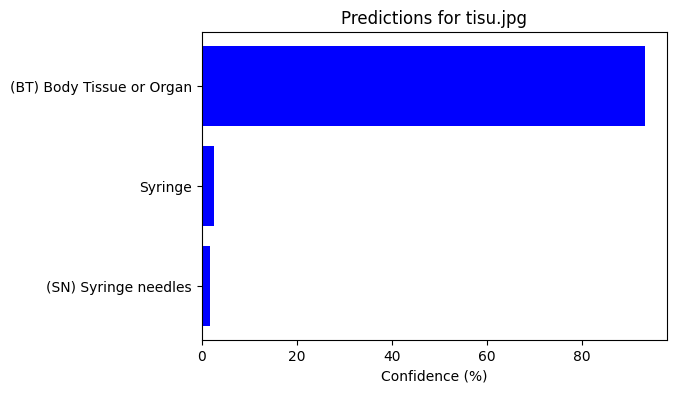

In [52]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define preprocessing steps (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load class labels (Update with your dataset classes)
class_labels = ['(BT) Body Tissue or Organ',
 '(GE) Glass equipment-packaging 551',
 '(ME) Metal equipment -packaging',
 '(OW) Organic wastes',
 '(PE) Plastic equipment-packaging',
 '(PP) Paper equipment-packaging',
 '(SN) Syringe needles',
 '.DS_Store',
 'Gauze',
 'Gloves',
 'Mask',
 'Syringe',
 'Tweezers']

# Define a list of image paths
image_paths = [
    "sample.webp", 
    "ThreeTypesOfGauze.jpeg",
    "glove.jpg",
    "lem.webp",
    "con.webp",
    "tisu.jpg"
]  # Replace with actual file paths

# Loop through all images in the array
for img_path in image_paths:
    image = Image.open(img_path)
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Convert to probabilities
        top_probs, top_classes = torch.topk(probabilities, 3)  # Get top 3 predictions

    # Convert to numpy for plotting
    top_probs = top_probs.cpu().numpy()
    top_classes = top_classes.cpu().numpy()

    # Display the image and predictions
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image: {img_path}")

    # Print predictions
    print(f"\n🔹 Predictions for {img_path}:")
    for i in range(3):
        class_name = class_labels[top_classes[i]]
        confidence = top_probs[i] * 100
        print(f"{class_name}: {confidence:.2f}%")

    # Create a bar plot for the top predictions
    plt.figure(figsize=(6, 4))
    plt.barh([class_labels[i] for i in top_classes], top_probs * 100, color="blue")
    plt.xlabel("Confidence (%)")
    plt.title(f"Predictions for {img_path}")
    plt.gca().invert_yaxis()
    plt.show()


In [53]:
torch.save(model, "best_model_full.pth")
